In [ ]:
#networkx para teoría de grafos, matplot para gráficar, random para generar números aleatorios, stats para la entropia y solve para optimizar.
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp 
from scipy import stats as st
import math 
from scipy.optimize import fsolve

In [ ]:
#La siguiente función nuestrea secuencias de números con la distribución del vector de probabilidades acumuladas
def Degree_Sec_Generator(Probabilidad_Acumulada,longitud_Secuencia):
  """
  (Vector Probabilidada Acumulada, Longitud Secuencia) -------> Secuencia de enteros con la distribución del vector
  """
  Degree_Sequence = []
  for i in range(longitud_Secuencia):
    k = st.uniform.rvs(scale = Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]) #Se generan números aleatoriamente entre 0 y 0.9999
    for j in range(len(Probabilidad_Acumulada)-2):
      if k <= Probabilidad_Acumulada[j+2]: # Asocia un entero positivo a cada número entre 0-0.9999
        Degree_Sequence.append(j+2) #construye el vector con los enteros positivos asociados a los números entre 0-1
        break
  return Degree_Sequence

In [ ]:
#esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto en el proyecto que sustenta este respositorio
def maxent_generator(cum_probability,number_nodes,m):
  """
  (cum_probability,number_nodes) -----> G
  esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto
  en el proyecto que sustenta este respositorio
  """
  for k in range(1000000000000):
          Degree_Sequence = Degree_Sec_Generator(cum_probability,number_nodes,m) #se genera secuencia
          if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
            if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True: #se comprueba si permite crear un grafo simple conectado
              Degree_Sequence.sort() #ordenamos la secuencia
              Grafo = nx.havel_hakimi_graph(Degree_Sequence) #creamos el grafo con el algoritmo havel hakimi
              break
  nx.double_edge_swap(Grafo,nswap=1000,max_tries=150000) #Se aleatoriza el grafo manteniendo su secuencia de grado constante
  return Grafo

In [ ]:
#esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto
#en el proyecto que sustenta este respositorio
def maxent_generator(cum_probability,number_nodes):
  """
  (cum_probability,number_nodes) -----> G
  esta función recibe vector de probabilidades acumulada y un entero, te entrega un grafo generado con el algoritmo expuesto
  en el proyecto que sustenta este respositorio
  """
  for k in range(10000):
          Degree_Sequence = Degree_Sec_Generator(cum_probability,number_nodes) #se genera secuencia
          if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
            if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True: #se comprueba si permite crear un grafo simple conectado
              Degree_Sequence.sort() #ordenamos la secuencia
              G = nx.havel_hakimi_graph(Degree_Sequence) #creamos el grafo con el algoritmo havel hakimi
              break
  nx.double_edge_swap(G,nswap=200,max_tries=150000) #Se aleatoriza el grafo manteniendo su secuencia de grado constante
  return G

In [ ]:
#Estas funciones remueven N nodos o enlaces del grafo ingresado
def remove_hubs_load(G,nodos_removidos): #remueve nodos con mayor load
  """
  (G, #nodos_removidos) ---------> G
  """
  for i in range(nodos_removidos):
    keys = list(nx.load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_nodo = values.index(maxval)
    G.remove_node(keys[casilla_nodo])
  return G

def edge_remove_hub_load(G,edges_removidos): #remueve edges con mayor load
  """
  (G,#edges_removidos) -------> G
  """
  for i in range(edges_removidos):
    keys = list(nx.edge_load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_edge = values.index(maxval)
    G.remove_edge(keys[casilla_edge][0],keys[casilla_edge][1])
  return G


def remove_aleatory(G,nodos_removidos): #remueve nodos aleatoriamente
  """
  (G,#nodos_removidos) -----------> G
  """
  keys = list(G.nodes())
  for i in range(nodos_removidos):
    remove_node = np.random.randint(0,G.number_of_nodes())
    remnode = keys[remove_node]
    if (remnode in G) == True:
      G.remove_node(remnode)
  return G

def edge_remove_aleatory(G,edges_removidos): #remueve edges aleatoriamente
  """
  (G,#edges_removidos) ------> G
  """
  for i in range(edges_removidos):
    remove_edge = np.random.randint(0,len(nx.edges(G)))
    if (remove_edge in G) ==True:
      G.remove_edge(list(nx.edges(G))[remove_edge][0],list(nx.edges(G))[remove_edge][1])
  return G

In [ ]:
#Estas dos funciones atacan nodos y enlaces en base al ranking en la medida fload y causan una falla en cascada
# la falla en cascada se realiza recalculando el load en la red y eliminando con cierta probabilidad los nodos que tengan un load mayor 
# a su loadinicial*resiliencia, si el load supera un valor dado la probabilidad de eliminación es 100%

def hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  Esta función ataca nodos acorde a su ranking en la medida load y luego aplica una falla en cascada
  acorde a que nodos soportan un mayor load que el dado por su capacidad inicial y resiliencia
  """
  load1 = nx.load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  nodes = len(G.nodes())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    remove_hubs_load(G,1) #se remueve el nodo con mayor load
    DELETE_NODES = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual un nodo colapsara con 100% de seguridad
      if load[j] > val: 
        DELETE_NODES.append(j) #enlistamos los nodos que colapsaran
      else:
        if load[j] > Capacity[keys1.index(j)]:#se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/Capacity[keys1.index(j)] -1)
          if k <= P:
            DELETE_NODES.append(j) #enlistamos los nodos colapsados
    G.remove_nodes_from(DELETE_NODES) #se eliminan los nodos colapsados
    NodosBC = len(max(nx.connected_components(G), key=len))
    DAMAGE.append(NodosBC/nodes) #registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
  return G,ATTACK,DAMAGE

def edge_hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  Esta función ataca nodos acorde a su ranking en la medida load y luego aplica una falla en cascada
  acorde a que nodos soportan un mayor load que el dado por su capacidad inicial y resiliencia
  """
  load1 = nx.edge_load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGEEDGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    edge_remove_hub_load(G,1) #se remueve el edge con mas load 
    DELETE_EDGES = []
    load = nx.edge_load_centrality(G)
    for j in G.edges():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual un nodo colapsara con 100% de seguridad
      if load[j] > val:  #enlistamos los nodos que colapsaran
        DELETE_EDGES.append(j)
      else:
        if load[j] > Capacity[keys1.index(j)]: #se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia -1))*(load[j]/Capacity[keys1.index(j)] - 1)
          if k <= P:
            DELETE_EDGES.append(j) #enlistamos los nodos colapsados
    G.remove_edges_from(DELETE_EDGES) #se eliminan los nodos colapsados
    NodosBC = len(max(nx.connected_components(G), key = len))
    DAMAGEEDGE.append(NodosBC/len(G.nodes()))#registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
  return G, ATTACK, DAMAGEEDGE

In [ ]:
def aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el número de ataques)
  Esta función luego de atacar un nodo aleatoriamente ejecuta el algoritmo de falla en cascada y te entrega como resultado
  el grafo atacado, un vector con los daños por ataque y un vector con el número de ataques
  """
  load1 = nx.load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  nodes = len(G.nodes())
  Capacity = []
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGE = []
  ATTACK = []
  for i in range(Number_Attacks): #en este for se ejecutan los ataques
    remove_aleatory(G,1) #se remueve un nodo aleatoriamente
    DELETE_NODES = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      val = Resiliencia*Capacity[keys1.index(j)] #calculamos el valor de load sobre el cual el nodo colapsara con 100% de probabilidad
      if load[j] > val: 
        DELETE_NODES.append(j) #enlistamos los nodos colapsados
      else:
        if load[j] > Capacity[keys1.index(j)]: # se decide si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/Capacity[keys1.index(j)] -1)
          if k <= P:
            DELETE_NODES.append(j) #enlistamos los nodos colapsados
    G.remove_nodes_from(DELETE_NODES) #se eliminan los nodos colapsados
    NodosBC = len(max(nx.connected_components(G), key=len))
    DAMAGE.append(NodosBC/nodes) #registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el número de ataque
  return G,ATTACK,DAMAGE

def edge_aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el número de ataques)
  Esta función luego de atacar un enlace aleatoriamente ejecuta el algoritmo de falla en cascada y te entrega como resultado
  el grafo atacado, un vector con los daños por ataque y un vector con el número de ataques
  """
  load1 = nx.edge_load_centrality(G)
  keys1 = list(load1.keys())
  values1 = list(load1.values())
  Capacity = []
  nodes = len(G.nodes())
  for i in range(len(keys1)): #se definen condiciones iniciales
    q = (1+Initial_Capacity)*load1[keys1[i]]
    Capacity.append(q)
  DAMAGEEDGE = []
  ATTACK = []
  for i in range(Number_attacks): #en este for se ejecutan los ataques
    edge_remove_aleatory(G,1) #se remueve un edge aleatoriamente
    DELETE_EDGES = []
    load = nx.edge_load_centrality(G)
    for j in G.edges():
      val = Resiliencia*Capacity[keys1.index(j)] #calcula el valor de load sobre el cual un nodo colapsara con 100% de probabilidad
      if load[j] > val: 
        DELETE_EDGES.append(j) #enlistamos nodos colapsados
      else:
        if load[j] > Capacity[keys1.index(j)]: #se elige si un nodo que ha superado su capacidad colapsa
          k = st.uniform.rvs()
          P = (1/(Resiliencia -1))*(load[j]/Capacity[keys1.index(j)] - 1)
          if k <= P:
            DELETE_EDGES.append(j)
    G.remove_edges_from(DELETE_EDGES) #enlistamos nodos colapsados
    NodosBC = len(max(nx.connected_components(G), key = len)) 
    DAMAGEEDGE.append(NodosBC/nodes) #registramos el daño con el cambio en el tamaño de la componente principal
    ATTACK.append(i) #registramos el numero de ataque
  return G, ATTACK, DAMAGEEDGE

In [ ]:
# Está función calcula la entropía de distintas distribuciones de medidas para un grafo
def graph_entropys(G):
  """
  Recibe un grafo y entrega números
  (Graph) -----> Degree_Entropy, Eigenvector_Entropy, Betweenness_Entropy, Closeness_Entropy
  """
  EIGENVECTOR = []
  DEGREE = []
  BETWEENNESS = []
  CLOSENESS = []
  load = []
  #las siguientes 4 lineas producen 4 diccionarios con los nodos y sus centralidades correspondientes
  eigenvector = nx.eigenvector_centrality(G)
  degree = nx.degree(G) 
  betweenness = nx.betweenness_centrality(G) 
  closeness = nx.closeness_centrality(G) 
  load = nx.load
  for i in range(len(eigenvector)): #este for desempaqueta los diccionarios, para coger solo las centralidades en listas
    EIGENVECTOR.append(eigenvector[i])
    DEGREE.append(degree[i])
    BETWEENNESS.append(betweenness[i])
    CLOSENESS.append(closeness[i])
  # aca se usa el modulo stats de scipy para calcular las entropias
  Closeness_Entropy = st.entropy(CLOSENESS)
  Degree_Entropy = st.entropy(DEGREE)
  Eigenvector_Entropy = st.entropy(EIGENVECTOR)
  Betweenness_Entropy = st.entropy(BETWEENNESS)
  return Degree_Entropy, Eigenvector_Entropy, Betweenness_Entropy, Closeness_Entropy

#DESDE ACA EMPIEZA LA PREUBA

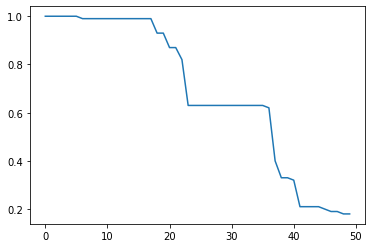

In [ ]:
G = nx.barabasi_albert_graph(100,2)
G, ATTACK, DAMAGE = edge_hub_cascade_failure(G,1,1.1,50)
plt.plot(ATTACK,DAMAGE)

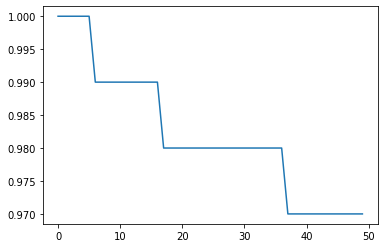

In [ ]:
G = nx.barabasi_albert_graph(100,2)
G, ATTACK, DAMAGE = edge_aleatory_cascade_failure(G,1,1.1,50)
plt.plot(ATTACK,DAMAGE)

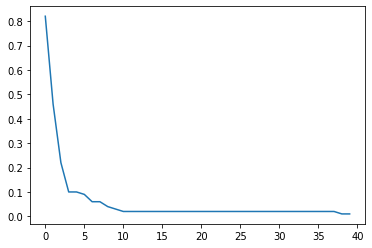

In [ ]:
G = nx.barabasi_albert_graph(100,2)
G, ATTACK, DAMAGE = hub_cascade_failure(G,1,1.1,40)
plt.plot(ATTACK,DAMAGE)

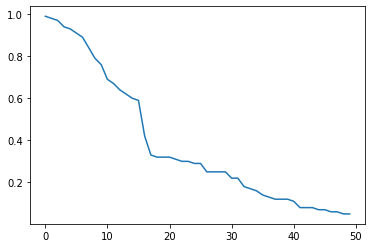

In [ ]:
G = nx.barabasi_albert_graph(100,2)
G, ATTACK, DAMAGE = aleatory_cascade_failure(G,1,1.1,50)
plt.plot(ATTACK,DAMAGE)